In [2]:
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler
from codefiles import *

In [13]:
G = nx.Graph()
with open("dataset/ca-GrQc.txt/CA-GrQc.txt", 'r') as f:
    for line in f:
        if line.startswith('#'):
            continue
        u, v = map(int, line.strip().split())
        G.add_edge(u, v)

In [14]:
G = G.subgraph(max(nx.connected_components(G), key=len))
    
# Create adjacency matrix
adj_matrix = nx.to_numpy_array(G)
adj_matrix.shape

(4158, 4158)

In [15]:
degree = np.array(list(dict(G.degree()).values()))
eigenvector = np.array(list(nx.eigenvector_centrality(G, max_iter=1000).values()))

In [16]:
node_features = degree #* eigenvector
#scaler = StandardScaler()
#node_features = scaler.fit_transform(node_features.reshape(-1,1)).flatten()

node_features.shape

(4158,)

In [17]:
nodes_to_keep = np.where(degree >= 10)[0]

filtered_adj_matrix = adj_matrix[np.ix_(nodes_to_keep, nodes_to_keep)]
filtered_node_features = node_features[nodes_to_keep]
filtered_adj_matrix.shape

(737, 737)

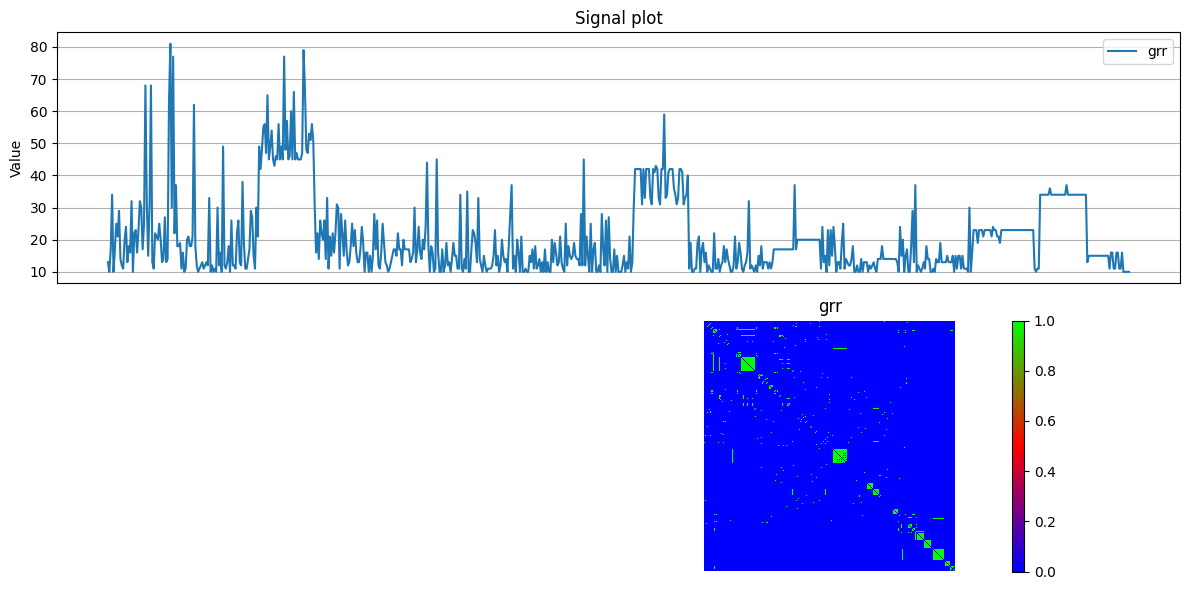

In [18]:
plot_arrays([("grr",filtered_node_features,filtered_adj_matrix)])

In [1]:
_,_,_ = VEMICL(filtered_adj_matrix,filtered_node_features,50)

NameError: name 'VEMICL' is not defined

In [40]:
theta, mu ,name,perm = VEMbasedV(filtered_adj_matrix,filtered_node_features,16,cluster=True,giveperm=True)

In [37]:
thatF,muF,nameF = ir_ls(filtered_adj_matrix,filtered_node_features[:,None],16)

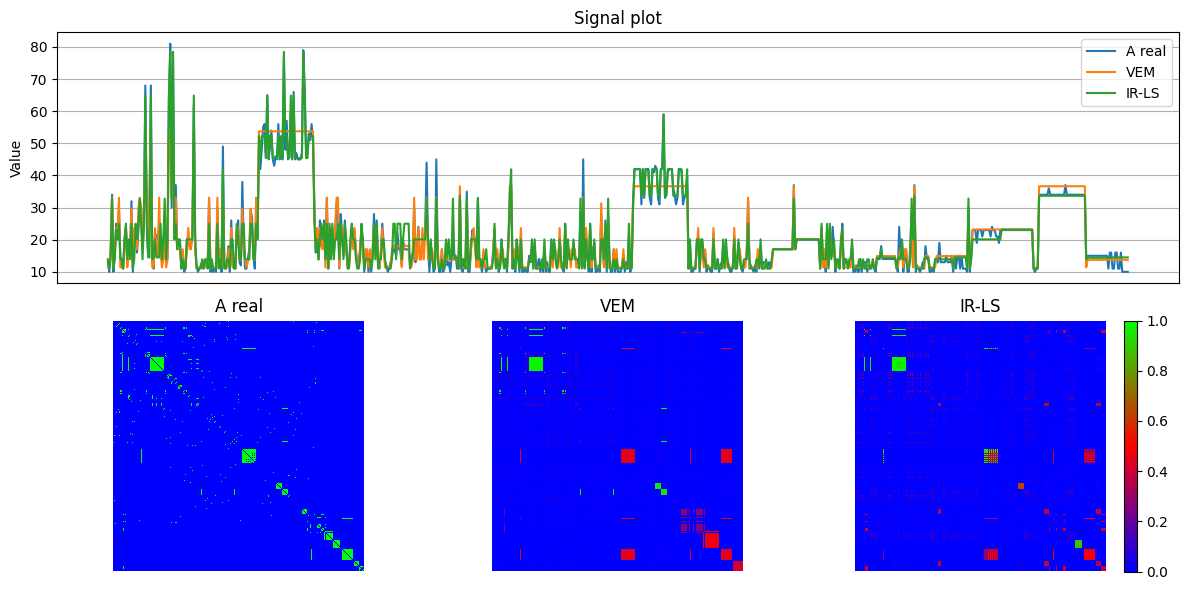

In [41]:
plot_arrays([("A real",filtered_node_features,filtered_adj_matrix),(name,mu,theta),(nameF,muF,thatF)])

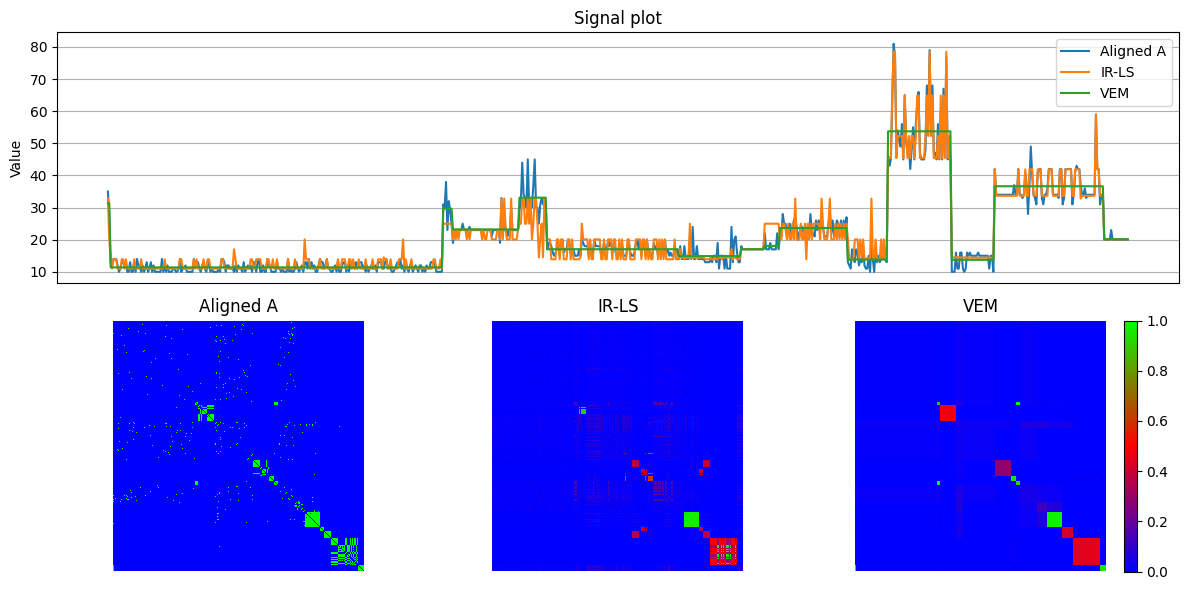

In [42]:
perm_adj_matrice = filtered_adj_matrix[perm,:]
perm_adj_matrice = perm_adj_matrice[:,perm]
perm_node_features = filtered_node_features[perm]

perm_theta = theta[perm,:]
perm_theta = perm_theta[:,perm]
perm_mu = mu[perm]

perm_thetaF = thatF[perm,:]
perm_thetaF = perm_thetaF[:,perm]
perm_muF = muF[perm]

plot_arrays([("Aligned A",perm_node_features,perm_adj_matrice),(nameF,perm_muF,perm_thetaF),("VEM",perm_mu,perm_theta)])

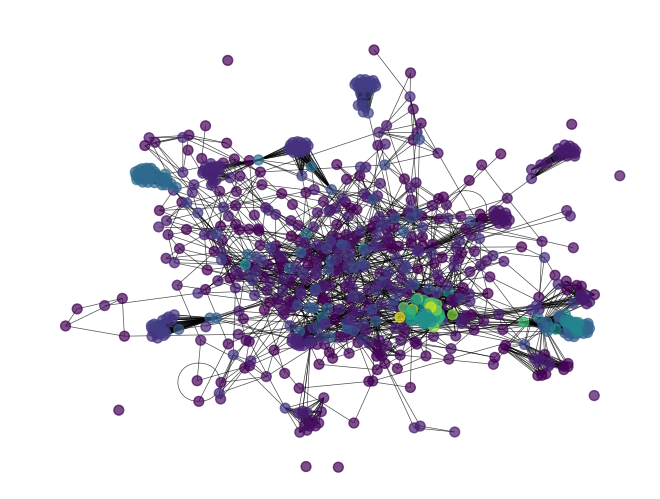

In [43]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(perm_node_features.reshape(-1,1)).flatten()

from matplotlib import cm
cmap = cm.viridis  # Choose a colormap (e.g., viridis, plasma, coolwarm)
node_colors = cmap(normalized_features)
G = nx.from_numpy_array(perm_adj_matrice)

pos = nx.spring_layout(G,k=0.15)
nx.draw(G, pos, 
        node_color=node_colors, 
        node_size=50,  # Adjust node size
        width=0.5,  # Adjust edge width
        with_labels=False,  # Consider hiding labels for better clarity
        alpha=0.7) 

In [5]:
## Twitch gamers dataset
import pandas as pd
edges_data = pd.read_csv("dataset/twitch_gamers/large_twitch_edges.csv")
node_features_data = pd.read_csv("dataset/twitch_gamers/large_twitch_features.csv")

In [6]:
node_features_data

,views,mature,life_time,created_at,updated_at,numeric_id,dead_account,language,affiliate
0,7879,1,969,2016-02-16,2018-10-12,0,0,EN,1
1,500,0,2699,2011-05-19,2018-10-08,1,0,EN,0
2,382502,1,3149,2010-02-27,2018-10-12,2,0,EN,1
3,386,0,1344,2015-01-26,2018-10-01,3,0,EN,0
4,2486,0,1784,2013-11-22,2018-10-11,4,0,EN,0
...,...,...,...,...,...,...,...,...,...
168109,4965,0,810,2016-07-20,2018-10-08,168109,0,EN,0
168110,4128,1,2080,2013-01-31,2018-10-12,168110,0,EN,0
168111,3545,0,1797,2013-11-08,2018-10-10,168111,0,EN,1
168112,892736,1,2135,2012-12-07,2018-10-12,168112,0,EN,0


In [24]:
filtered_nodes = node_features_data[
    (node_features_data["views"] >= 5000000) & (node_features_data["language"] == "EN")
]["numeric_id"].tolist()

len(filtered_nodes)

580

In [25]:
edges_data

,numeric_id_1,numeric_id_2
0,98343,141493
1,98343,58736
2,98343,140703
3,98343,151401
4,98343,157118
...,...,...
6797552,97507,29359
6797553,71175,12020
6797554,151702,128281
6797555,118034,38021


In [26]:
filtered_edges = edges_data[
    (edges_data["numeric_id_1"].isin(filtered_nodes)) & (edges_data["numeric_id_2"].isin(filtered_nodes))
]

In [27]:
unique_nodes = set(filtered_nodes)
node_id_to_index = {node_id: index for index, node_id in enumerate(unique_nodes)}
num_nodes = len(unique_nodes)
adjacency_matrix = np.zeros((num_nodes, num_nodes))
for index, row in filtered_edges.iterrows():
    from_index = node_id_to_index[row["numeric_id_1"]]
    to_index = node_id_to_index[row["numeric_id_2"]]
    adjacency_matrix[from_index, to_index] = 1
    adjacency_matrix[to_index, from_index] = 1

adjacency_matrix.shape

(580, 580)

In [28]:
filtered_node_features = node_features_data[node_features_data["numeric_id"].isin(filtered_nodes)]
filtered_node_features = filtered_node_features.set_index("numeric_id")
filtered_node_features = filtered_node_features.reindex(unique_nodes)
node_features_vector = filtered_node_features["views"].values

node_features_vector.shape

(580,)

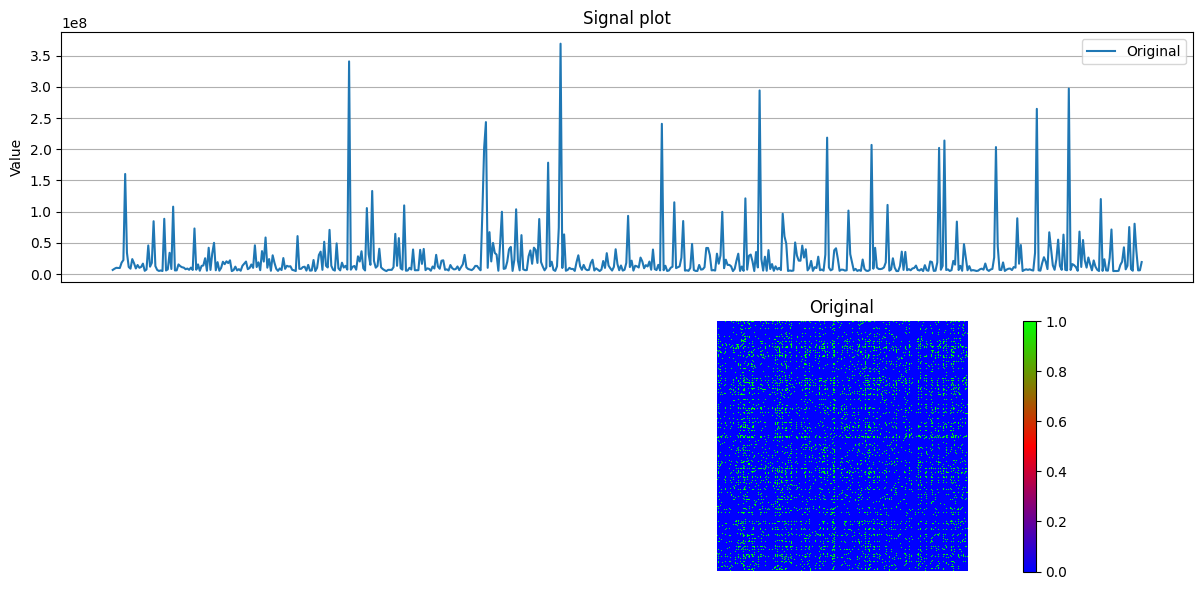

In [29]:
plot_arrays([("Original", node_features_vector, adjacency_matrix)])

In [14]:
_,_,_ = VEMICL(adjacency_matrix,node_features_vector,bound = 20)

15


In [34]:
theta2, mu2, name2,perm2 = VEMbasedV(adjacency_matrix,node_features_vector,15,cluster=True,giveperm=True)

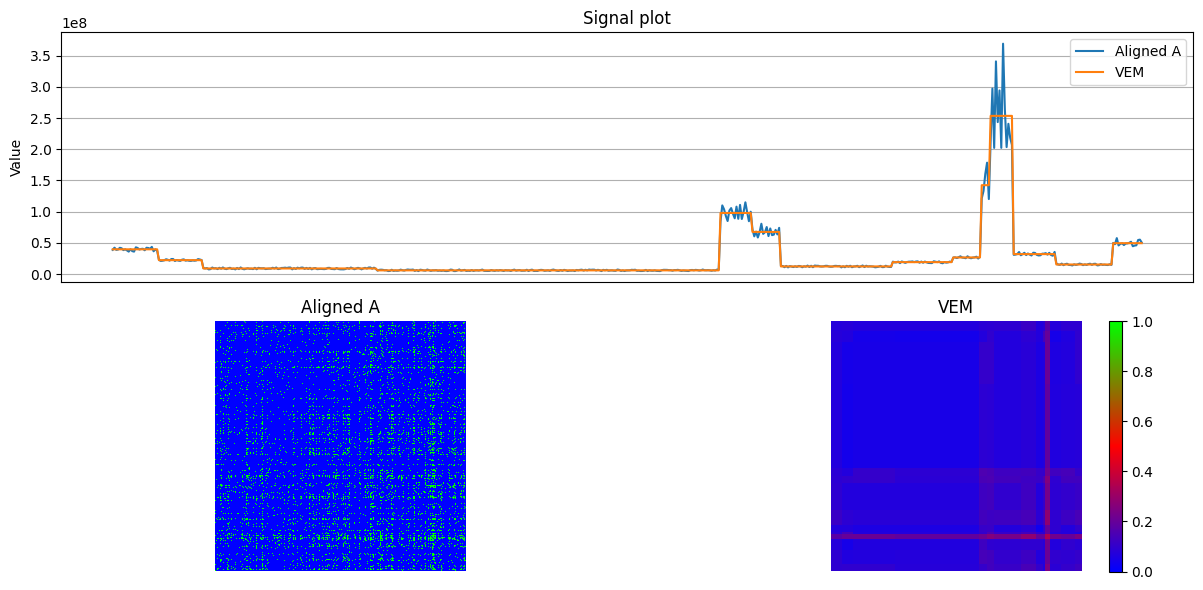

In [35]:
theta2perm = theta2[perm2,:]
theta2perm = theta2perm[:,perm2]
mu2perm = mu2[perm2]

adjperm2 = adjacency_matrix[perm2,:]
adjperm2 = adjperm2[:,perm2]
nfeatperm2 = node_features_vector[perm2]

plot_arrays([("Aligned A", nfeatperm2,adjperm2),("VEM",mu2perm,theta2perm)])